In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
cnts = pd.read_csv('counts__filt__norm.csv',index_col=0)
cnts.index = [_.split('.')[0] for _ in cnts.index]
cnts = cnts[cnts.mean(axis=1)>10]

# CNTL_0019 appears to be an outlier, remove it
#cols = [_ for _ in cnts.columns if _ != 'CNTL_0019_RNASeq_BA9_polyA']
#cnts = cnts[cols]

In [6]:
from matplotlib.pyplot import cm

In [7]:
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook

In [8]:
subset_size = 5000
niter = 500
nclust = 4
km_labels = []
inds = np.array(range(cnts.shape[1]))
for i in range(niter) :
    random_genes = np.random.choice(cnts.shape[0],size=subset_size)
    subset_cnts = cnts.iloc[random_genes]
    km = KMeans(n_clusters=nclust).fit(subset_cnts.T)
    km_labels.extend([inds[km.labels_==_] for _ in range(nclust)])

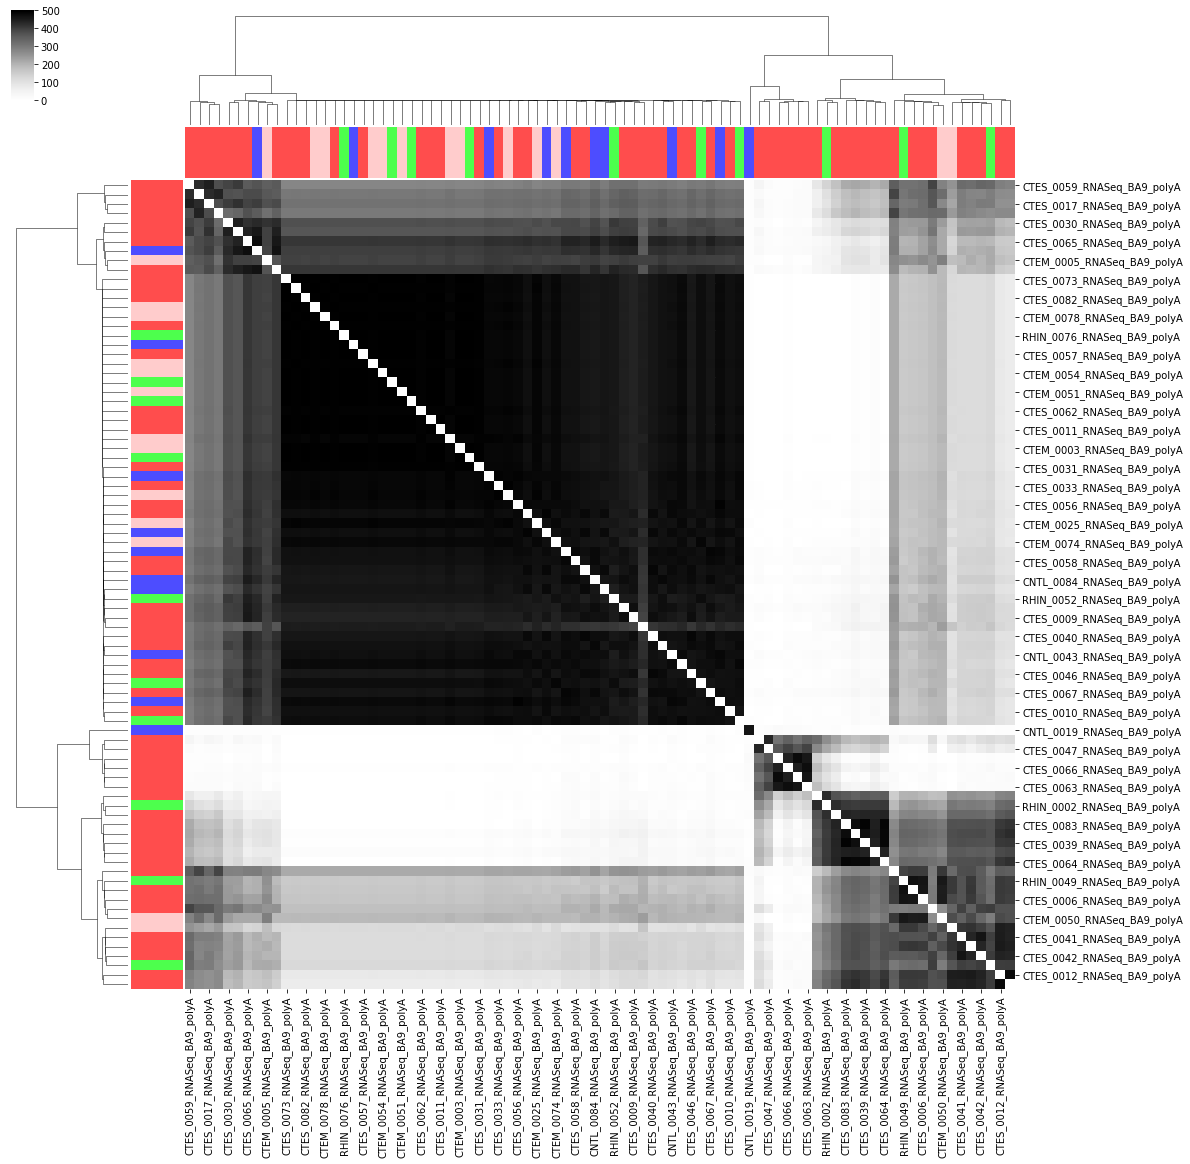

In [9]:
from itertools import permutations
partners = np.zeros(shape=[len(inds),len(inds)])
for labels in km_labels :
    if len(labels) == 0 :
        pass # empty cluster
    elif len(labels) == 1 :
        partners[labels[0],labels[0]] += 1
    else :
        for p1, p2 in permutations(labels,2) :
            partners[p1,p2] += 1

partners = pd.DataFrame(partners,index=cnts.columns,columns=cnts.columns)
colmap = {'CNTL':(0.3,0.3,1),'RHIN':(0.3,1,0.3),'CTEM':(1,0.8,0.8),'CTES':(1,0.3,0.3)}
cg = sns.clustermap(
    partners,
    cmap=cm.Greys,
    row_colors=[colmap[_[:4]] for _ in partners.columns],
    col_colors=[colmap[_[:4]] for _ in partners.columns],
    figsize=(18,18)
)

5


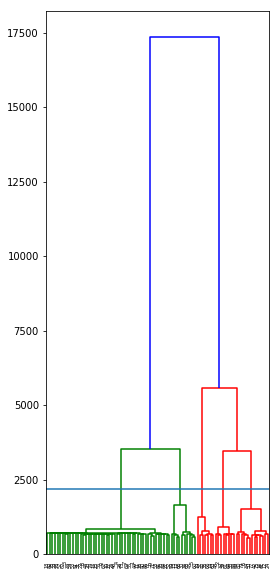

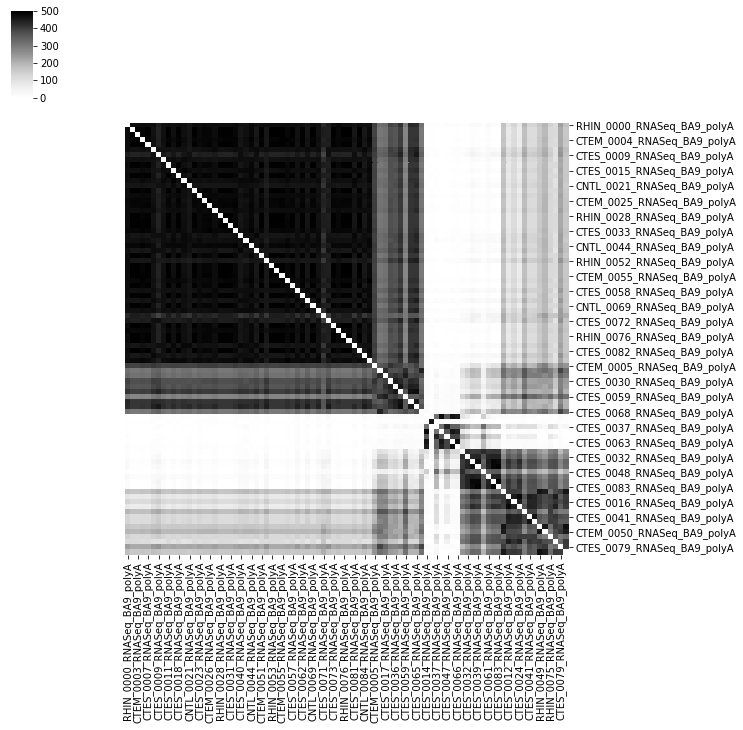

In [34]:
from itertools import chain
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list
from matplotlib.pyplot import *
clustered_columns = cnts.columns[cg.dendrogram_col.reordered_ind]
Z = linkage(partners,'ward')
figure(figsize=(4,10))
d = dendrogram(Z)
cut = 2200
axhline(cut);
clusters = fcluster(Z,cut,criterion='distance')
cluster_samples = [cnts.columns[inds[clusters==_]] for _ in range(1,max(clusters)+1)]
sns.clustermap(
    partners.loc[list(chain(*cluster_samples)),list(chain(*cluster_samples))],
    col_cluster=False,
    row_cluster=False,
    cmap=cm.Greys
)
print(len(cluster_samples))

In [35]:
from collections import defaultdict
cluster_samples_grouped = defaultdict(list)
sample_map = {}
for label, names in zip(range(len(cluster_samples)), cluster_samples) :
    cluster_samples_grouped[label].extend(names)
    for name in names:
        sample_map[name] = label

In [36]:
covs = pd.read_csv('../CTE_sample_info.csv')
covs.index = covs.ID
covs['Cluster'] = [sample_map[_] for _ in covs.index]
#covs['GuessedID'] = ['{}_{:04d}_RNASeq_BA9_polyA'.format(_[1],_[0]) for _ in enumerate(covs.GuessedStatus)]
covs = covs[['ID','Status','Cluster','SampleName','AgeAtDeath','APOEStatus','TMEM106B_rs1990622','TMEM106B_rs3173615','RIN','Seq_Batch']]
covs.to_csv('../CTE_sample_info_guessed.csv',index=False)

covs[covs.Status.isin(('CTEM','CNTL'))].to_csv('CTEM_CNTL_sample_info_guessed.csv',index=False)
covs[covs.Status.isin(('CTES','CNTL'))].to_csv('CTES_CNTL_sample_info_guessed.csv',index=False)
covs[covs.Status.isin(('RHIN','CNTL'))].to_csv('RHIN_CNTL_sample_info_guessed.csv',index=False)

In [33]:
covs.sort_values('Status')

ID  Status  Cluster  \
ID                                                                        
CNTL_0085_RNASeq_BA9_polyA  CNTL_0085_RNASeq_BA9_polyA     CNT        0   
CNTL_0043_RNASeq_BA9_polyA  CNTL_0043_RNASeq_BA9_polyA     CNT        0   
CNTL_0084_RNASeq_BA9_polyA  CNTL_0084_RNASeq_BA9_polyA     CNT        0   
CNTL_0044_RNASeq_BA9_polyA  CNTL_0044_RNASeq_BA9_polyA     CNT        0   
CNTL_0021_RNASeq_BA9_polyA  CNTL_0021_RNASeq_BA9_polyA     CNT        0   
CNTL_0020_RNASeq_BA9_polyA  CNTL_0020_RNASeq_BA9_polyA     CNT        0   
CNTL_0019_RNASeq_BA9_polyA  CNTL_0019_RNASeq_BA9_polyA     CNT        2   
CNTL_0069_RNASeq_BA9_polyA  CNTL_0069_RNASeq_BA9_polyA     CNT        0   
CNTL_0070_RNASeq_BA9_polyA  CNTL_0070_RNASeq_BA9_polyA     CNT        0   
CNTL_0045_RNASeq_BA9_polyA  CNTL_0045_RNASeq_BA9_polyA     CNT        1   
CTEM_0077_RNASeq_BA9_polyA  CTEM_0077_RNASeq_BA9_polyA  CTE_12        4   
CTEM_0078_RNASeq_BA9_polyA  CTEM_0078_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0026_RNASeq_BA9_polyA  CTEM_0026_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0025_RNASeq_BA9_polyA  CTEM_0025_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0003_RNASeq_BA9_polyA  CTEM_0003_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0004_RNASeq_BA9_polyA  CTEM_0004_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0029_RNASeq_BA9_polyA  CTEM_0029_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0055_RNASeq_BA9_polyA  CTEM_0055_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0005_RNASeq_BA9_polyA  CTEM_0005_RNASeq_BA9_polyA  CTE_12        1   
CTEM_0051_RNASeq_BA9_polyA  CTEM_0051_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0050_RNASeq_BA9_polyA  CTEM_0050_RNASeq_BA9_polyA  CTE_12        4   
CTEM_0074_RNASeq_BA9_polyA  CTEM_0074_RNASeq_BA9_polyA  CTE_12        0   
CTEM_0054_RNASeq_BA9_polyA  CTEM_0054_RNASeq_BA9_polyA  CTE_12        0   
CTES_0048_RNASeq_BA9_polyA  CTES_0048_RNASeq_BA9_polyA  CTE_34        3   
CTES_0047_RNASeq_BA9_polyA  CTES_0047_RNASeq_BA9_polyA  CTE_34        2   
CTES_0056_RNASeq_BA9_polyA  CTES_0056_RNASeq_BA9_polyA  CTE_34        0   
CTES_0057_RNASeq_BA9_polyA  CTES_0057_RNASeq_BA9_polyA  CTE_34        0   
CTES_0082_RNASeq_BA9_polyA  CTES_0082_RNASeq_BA9_polyA  CTE_34        0   
CTES_0083_RNASeq_BA9_polyA  CTES_0083_RNASeq_BA9_polyA  CTE_34        3   
CTES_0058_RNASeq_BA9_polyA  CTES_0058_RNASeq_BA9_polyA  CTE_34        0   
...                                                ...     ...      ...   
CTES_0011_RNASeq_BA9_polyA  CTES_0011_RNASeq_BA9_polyA  CTE_34        0   
CTES_0010_RNASeq_BA9_polyA  CTES_0010_RNASeq_BA9_polyA  CTE_34        0   
CTES_0009_RNASeq_BA9_polyA  CTES_0009_RNASeq_BA9_polyA  CTE_34        0   
CTES_0008_RNASeq_BA9_polyA  CTES_0008_RNASeq_BA9_polyA  CTE_34        0   
CTES_0007_RNASeq_BA9_polyA  CTES_0007_RNASeq_BA9_polyA  CTE_34        0   
CTES_0006_RNASeq_BA9_polyA  CTES_0006_RNASeq_BA9_polyA  CTE_34        4   
CTES_0012_RNASeq_BA9_polyA  CTES_0012_RNASeq_BA9_polyA  CTE_34        4   
CTES_0024_RNASeq_BA9_polyA  CTES_0024_RNASeq_BA9_polyA  CTE_34        4   
CTES_0022_RNASeq_BA9_polyA  CTES_0022_RNASeq_BA9_polyA  CTE_34        0   
CTES_0030_RNASeq_BA9_polyA  CTES_0030_RNASeq_BA9_polyA  CTE_34        1   
CTES_0031_RNASeq_BA9_polyA  CTES_0031_RNASeq_BA9_polyA  CTE_34        0   
CTES_0032_RNASeq_BA9_polyA  CTES_0032_RNASeq_BA9_polyA  CTE_34        3   
CTES_0033_RNASeq_BA9_polyA  CTES_0033_RNASeq_BA9_polyA  CTE_34        0   
CTES_0034_RNASeq_BA9_polyA  CTES_0034_RNASeq_BA9_polyA  CTE_34        4   
CTES_0035_RNASeq_BA9_polyA  CTES_0035_RNASeq_BA9_polyA  CTE_34        3   
CTES_0036_RNASeq_BA9_polyA  CTES_0036_RNASeq_BA9_polyA  CTE_34        1   
CTES_0037_RNASeq_BA9_polyA  CTES_0037_RNASeq_BA9_polyA  CTE_34        2   
CTES_0040_RNASeq_BA9_polyA  CTES_0040_RNASeq_BA9_polyA  CTE_34        0   
CTES_0038_RNASeq_BA9_polyA  CTES_0038_RNASeq_BA9_polyA  CTE_34        2   
CTES_0039_RNASeq_BA9_polyA  CTES_0039_RNASeq_BA9_polyA  CTE_34        3   
RHIN_0028_RNASeq_BA9_polyA  RHIN_0028_RNASeq_BA9_polyA     RHI        0   
RH